# Hierarchical Soccer Model
+ Introduction
+ Data Prep
+ Model 1.1 - Hierarchical - direct lift from original paper
+ About League Football
+ Forward Model
+ Model 1.2 - Non Hierarchical Model
+ Why Hierarchical?
+ Model 1.3 - Hierarchical with modified prior distributions
+ Hierarchical Model Troubleshooting
+ Model 1.4 - Non-centred Hierarchical Model
+ Comparison of model 1.4 Results to Original Paper
+ Shrinkage
+ Summary
+ Resources

In [1]:
import os
import sys
import itertools
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotnine as p9
from plotnine import *

import pymc as pm
import arviz as az
import pytensor.tensor as pt
import arviz as az
# from scipy.stats import poisson

%load_ext dotenv
%dotenv
PROJECT_DIR=Path(os.environ.get('PROJECT_DIR'))
sys.path.append(str(PROJECT_DIR))
from notebooks.scripts.helpers import make_1x2_calib_data, format_season_df

In [2]:
# %matplotlib inline
%load_ext autoreload
%autoreload 2

theme_set(theme_bw())
pd.set_option('display.max_columns', 100)
SEED = 1925
LOCAL_DATA_DIR = PROJECT_DIR / 'data'
LOCAL_DATA_DIR

PosixPath('/media/david/T7/code/model-bettor/soccer-preds-001/hierarchical-soccer-model/data')

In [3]:
%load_ext watermark
%watermark --iversions

pandas    : 2.0.3
arviz     : 0.16.1
plotnine  : 0.12.2
pymc      : 5.7.1
matplotlib: 3.7.2
sys       : 3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:39:03) 
[GCC 11.3.0]
numpy     : 1.24.4
pytensor  : 2.14.2



# Data Prep
### Italy Serie A 1992-1993

In [4]:
df_orig1 = pd.read_parquet(LOCAL_DATA_DIR / 'italy_serie-a_1991-1992.parquet')
df_orig1

Wk  Day       Date           Home        Away           Referee  \
0     1  Sun 1991-09-01         Napoli    Atalanta   Piero Ceccarini   
1     1  Sun 1991-09-01       Juventus  Fiorentina  Angelo Amendolia   
2     1  Sun 1991-09-01          Lazio       Parma   Carlo Sguizzato   
3     1  Sun 1991-09-01       Cagliari   Sampdoria    Gianni Beschin   
4     1  Sun 1991-09-01           Bari      Torino   Loris Stafoggia   
..   ..  ...        ...            ...         ...               ...   
301  34  Sun 1992-05-24           Roma        Bari  Angelo Amendolia   
302  34  Sun 1992-05-24          Parma  Fiorentina    Massimo Chiesa   
303  34  Sun 1992-05-24       Cagliari       Lazio   Graziano Cesari   
304  34  Sun 1992-05-24      Sampdoria   Cremonese    Roberto Bettin   
305  34  Sun 1992-05-24  Hellas Verona    Juventus  Paolo De Angelis   

     h_ftgoals  a_ftgoals  
0          1.0        0.0  
1          1.0        0.0  
2          1.0        1.0  
3          3.0        2.0  
4          1.0        1.0  
..         ...        ...  
301        2.0        0.0  
302        1.0        1.0  
303        0.0        1.0  
304        2.0        2.0  
305        3.0        3.0  

[306 rows x 8 columns]

### Modify column names to match original paper

In [5]:
df = df_orig1.copy()
df, team_dict = format_season_df(df_orig1)
df

g      home        away  hg  ag  yg1  yg2 result
0      0    Verona        Roma  17  14  0.0  1.0   awin
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin
2      2     Lazio       Parma  10  13  1.0  1.0   draw
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin
4      4     Inter      Foggia   8   6  1.0  1.0   draw
..   ...       ...         ...  ..  ..  ...  ...    ...
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin
303  303     Inter    Atalanta   8   1  0.0  0.0   draw
304  304    Foggia       Milan   6  11  2.0  8.0   awin
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin

[306 rows x 8 columns]

In [6]:
# team_dict

{'Ascoli': 0,
 'Atalanta': 1,
 'Bari': 2,
 'Cagliari': 3,
 'Cremonese': 4,
 'Fiorentina': 5,
 'Foggia': 6,
 'Genoa': 7,
 'Inter': 8,
 'Juventus': 9,
 'Lazio': 10,
 'Milan': 11,
 'Napoli': 12,
 'Parma': 13,
 'Roma': 14,
 'Sampdoria': 15,
 'Torino': 16,
 'Verona': 17}

# Model 1.1 - Hierarchical - direct lift from original paper
+ First model as described in the paper - [Bayesian hierarchical model for the prediction of football results - section 2 - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ Code directly translated from original winbugs code to pymc
+ Variables renamed to correspond to naming in original paper

In [7]:
n_teams = df['hg'].nunique()
home_idx = df['hg'].values
away_idx = df['ag'].values
home_goals = df['yg1'].values
away_goals = df['yg2'].values
print(f'n_teams: {n_teams}')
print(f'home team indices (home_idx): {home_idx[0:5]}...')
print(f'away team indices (away_idx): {away_idx[0:5]}...')
print(f'home goals : {home_goals[0:5]}...')
print(f'away goals: {away_goals[0:5]}...')
tau = 0.0001
sigma = np.sqrt(1.0/tau)
print(f'sigma: {sigma}')

n_teams: 18
home team indices (home_idx): [17 12 10  9  8]...
away team indices (away_idx): [14  1 13  5  6]...
home goals : [0. 1. 1. 1. 1.]...
away goals: [1. 0. 1. 0. 1.]...
sigma: 100.0


In [8]:
with pm.Model() as model1_1:
    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=0, sigma=sigma)
    tau_att = pm.Gamma('tau_att', 0.01, 0.01)    
    mu_def = pm.Normal('mu_def', mu=0, sigma=sigma)
    tau_def = pm.Gamma('tau_def', 0.01, 0.01)

    # priors
    home = pm.Normal("home", mu=0, sigma=sigma)
    att_t = pm.Normal('att_t', mu=mu_att, tau=tau_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, tau=tau_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

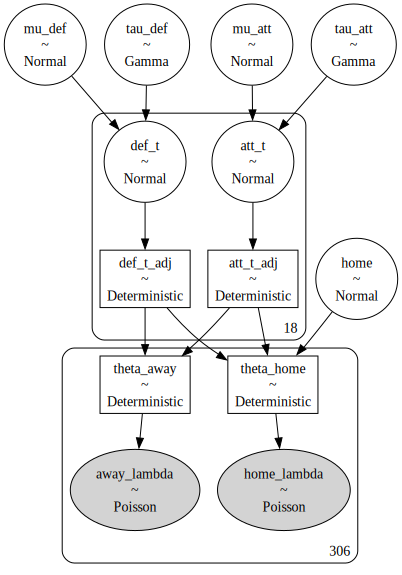

In [9]:
pm.model_to_graphviz(model1_1)

In [10]:
# # Crashes pymc - ValueError: lam value too large
# with model1_1:
#     idata1_1 = pm.sample_prior_predictive()

In [11]:
with model1_1:
    idata1_1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_att, tau_att, mu_def, tau_def, home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 183 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 20 divergences after tuning. Increase `target_accept` or reparameterize.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


In [12]:
# idata1_1

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

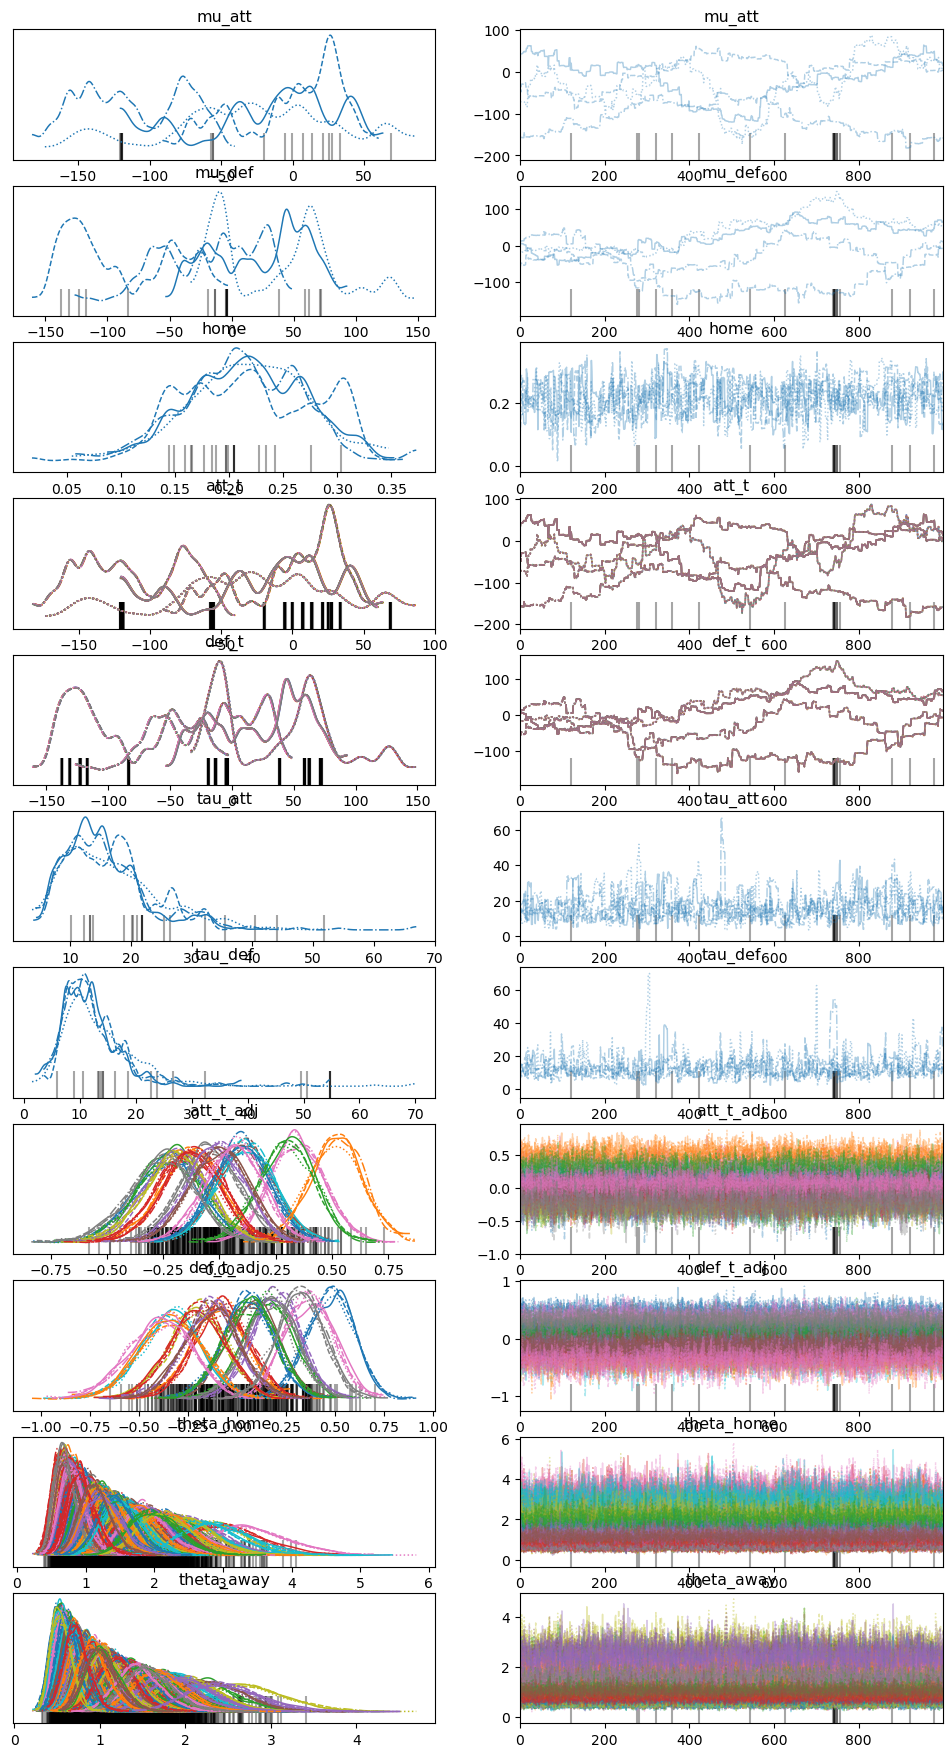

In [13]:
az.plot_trace(idata1_1);

# About League Football
+ Serie-a 1992-1993 season had 18 teams.
+ In a season - every team plays every other team in the league, once at home and once away.
+ The fixtures are sequenced so that a team alternates between home and away games.
+ This means the 1992-1993 season comprised 18 x 17 = 306 matches.
+ Every game can result in one of 3 outcomes - a home win, a draw or an away win.
+ At the end of every season 3 teams are relegated from the league, and 3 new teams are promoted into the league.
+ Football is a low scoring game, with a reasonably high degree of randomness. The distribution of goals can be modeled by a poisson distribution - See [Predicting Football Results With Statistical Modelling](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

# Forward Model
### Key Inputs
+ If we ignore the hierachical structure we have 3 key inputs
    + home advantage `home` (common across all teams)
    + attack ability `att_t` - The attacking strength of each team
    + defence ability `def_t` - The defending capability of each team
### Zero sum constraint   
+ The attack and defence abilities are adjusted/constrained to sum to zero. This is done by subtracting the mean attack ability (calculated across all teams) from the attack ability of each team. Same for defence.
### Link function and mean score calculation 
+ Every match in the fixture list has a two "expected goals" numbers - one for the home team and one for the away team. 
+ These are calculated using the adjusted attack and defence abilities which are fed into 2 equations for every match in the fixture list:
    + theta_home_team = exponential(home advantage + adj_attack[home team] + adj_defence[away_team])
    + theta_away_team = exponential(adj_attack[away_team] + adj_defence[home_team]
### Goal scoring data
+ We now have an "expected goals" number for the home team and the away team for every fixture. This number is modeled as the mean of a poisson distribution, so for each match in the fixture list, we can sample from the relevant poisson distributions to get a score.
### Approach
+ Build a forward model - try various inputs for home advantage, attack ability and defence ability - and get a feel for how well the model output matches the scores we expect to see in a top football league.

In [14]:
def simulate_season(home, fixtures):    
    fixtures['home_team_raw'] = home + fixtures['home_team_att'] + fixtures['away_team_def']
    fixtures['away_team_raw'] = fixtures['away_team_att'] + fixtures['home_team_def']
    fixtures['theta_home_team'] = np.exp(fixtures['home_team_raw'])
    fixtures['theta_away_team'] = np.exp(fixtures['away_team_raw'])

    fixtures['home_team_goals'] = np.random.poisson(lam=fixtures['theta_home_team'])
    fixtures['away_team_goals'] = np.random.poisson(lam=fixtures['theta_away_team'])

    return fixtures   

def apply_zero_sum_constraint(att_t, def_t):
    att_t_adj = att_t - np.mean(att_t)
    def_t_adj = def_t - np.mean(def_t)
    
    return att_t_adj, def_t_adj
    
teams = [0, 1, 2]
fixtures = np.array(list(zip(*list(itertools.permutations(teams, 2))))).T
df_fixtures = pd.DataFrame(fixtures, columns=['home_team', 'away_team'])
df_fixtures

home_team  away_team
0          0          1
1          0          2
2          1          0
3          1          2
4          2          0
5          2          1

In [15]:
att_t = [1, 2, 3]
def_t = [1, 2, 3]

att_t_adj, def_t_adj = apply_zero_sum_constraint(att_t, def_t)
att_t_adj, def_t_adj

(array([-1.,  0.,  1.]), array([-1.,  0.,  1.]))

In [16]:
df_fixtures['home_team_att'] = df_fixtures['home_team'].map(lambda x: att_t_adj[x])
df_fixtures

home_team  away_team  home_team_att
0          0          1           -1.0
1          0          2           -1.0
2          1          0            0.0
3          1          2            0.0
4          2          0            1.0
5          2          1            1.0

In [17]:
df_fixtures['home_team_def'] = df_fixtures['home_team'].map(lambda x: def_t_adj[x])
df_fixtures['away_team_att'] = df_fixtures['away_team'].map(lambda x: att_t_adj[x])
df_fixtures['away_team_def'] = df_fixtures['away_team'].map(lambda x: def_t_adj[x])
df_fixtures

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  
0            0.0  
1            1.0  
2           -1.0  
3            1.0  
4           -1.0  
5            0.0

In [18]:
home = 1
results = simulate_season(home, df_fixtures)
results

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0          0          1           -1.0           -1.0            0.0   
1          0          2           -1.0           -1.0            1.0   
2          1          0            0.0            0.0           -1.0   
3          1          2            0.0            0.0            1.0   
4          2          0            1.0            1.0           -1.0   
5          2          1            1.0            1.0            0.0   

   away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0            0.0            0.0           -1.0         1.000000   
1            1.0            1.0            0.0         2.718282   
2           -1.0            0.0           -1.0         1.000000   
3            1.0            2.0            1.0         7.389056   
4           -1.0            1.0            0.0         2.718282   
5            0.0            2.0            1.0         7.389056   

   theta_away_team  home_team_goals  away_team_goals  
0         0.367879                1                0  
1         1.000000                5                1  
2         0.367879                4                0  
3         2.718282               10                4  
4         1.000000                2                1  
5         2.718282                9                3

In [19]:
def forward_model(home, att_t, def_t, n_teams):
    teams = np.arange(n_teams)
    fixtures = np.array(list(zip(*list(itertools.permutations(teams, 2))))).T
    df_fixtures = pd.DataFrame(fixtures, columns=['home_team', 'away_team'])

    att_t_adj, def_t_adj = apply_zero_sum_constraint(att_t, def_t)

    df_fixtures['home_team_att'] = df_fixtures['home_team'].map(lambda x: att_t_adj[x])
    df_fixtures['home_team_def'] = df_fixtures['home_team'].map(lambda x: def_t_adj[x])
    df_fixtures['away_team_att'] = df_fixtures['away_team'].map(lambda x: att_t_adj[x])
    df_fixtures['away_team_def'] = df_fixtures['away_team'].map(lambda x: def_t_adj[x])

    return simulate_season(home, df_fixtures)

In [20]:
n_teams = 18
att_t = np.random.uniform(0, 20, size=n_teams)
def_t = np.random.uniform(0, 20, size=n_teams)
home = 10
season_sim = forward_model(home, att_t, def_t, n_teams)
season_sim

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0            0          1      -5.139800      -3.770691      -5.478807   
1            0          2      -5.139800      -3.770691      -5.492277   
2            0          3      -5.139800      -3.770691       5.891870   
3            0          4      -5.139800      -3.770691      -4.365891   
4            0          5      -5.139800      -3.770691       8.780686   
..         ...        ...            ...            ...            ...   
301         17         12       6.795348       6.216842      -4.128204   
302         17         13       6.795348       6.216842      -5.050770   
303         17         14       6.795348       6.216842      -1.594437   
304         17         15       6.795348       6.216842       6.677765   
305         17         16       6.795348       6.216842       8.068931   

     away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0        -7.321118      -2.460918      -9.249498     8.535653e-02   
1         5.584870      10.445070      -9.262968     3.437448e+04   
2        10.361617      15.221817       2.121179     4.080856e+06   
3        -7.470720      -2.610520      -8.136582     7.349630e-02   
4        -3.282431       1.577769       5.009995     4.844136e+00   
..             ...            ...            ...              ...   
301      -1.770126      15.025222       2.088638     3.352517e+06   
302       9.572929      26.368277       1.166073     2.828766e+11   
303      -2.307148      14.488200       4.622405     1.959499e+06   
304      -1.234114      15.561234      12.894608     5.730044e+06   
305       8.580934      25.376282      14.285773     1.049009e+11   

     theta_away_team  home_team_goals  away_team_goals  
0       9.615995e-05                0                0  
1       9.487332e-05            34385                0  
2       8.340970e+00          4078533                6  
3       2.926357e-04                0                0  
4       1.499040e+02                5              171  
..               ...              ...              ...  
301     8.073915e+00          3353703               11  
302     3.209363e+00     282876140256                6  
303     1.017385e+02          1960959              122  
304     3.981593e+05          5730281           397128  
305     1.600414e+06     104901400765          1597199  

[306 rows x 12 columns]

In [21]:
n_teams = 18
att_t = np.random.uniform(0, 3, size=n_teams)
def_t = np.random.uniform(-3, 0, size=n_teams)
home = 0.5
season_sim = forward_model(home, att_t, def_t, n_teams)
season_sim

home_team  away_team  home_team_att  home_team_def  away_team_att  \
0            0          1      -0.416055       1.730846       0.672081   
1            0          2      -0.416055       1.730846      -0.461922   
2            0          3      -0.416055       1.730846       0.333479   
3            0          4      -0.416055       1.730846       1.049738   
4            0          5      -0.416055       1.730846       0.467671   
..         ...        ...            ...            ...            ...   
301         17         12       0.277976      -0.995847       0.609867   
302         17         13       0.277976      -0.995847      -1.503180   
303         17         14       0.277976      -0.995847      -0.904303   
304         17         15       0.277976      -0.995847      -0.054640   
305         17         16       0.277976      -0.995847      -0.344445   

     away_team_def  home_team_raw  away_team_raw  theta_home_team  \
0         0.647410       0.731355       2.402927         2.077893   
1         0.113088       0.197033       1.268925         1.217785   
2        -0.431884      -0.347939       2.064325         0.706142   
3         0.037835       0.121780       2.780584         1.129505   
4        -0.541722      -0.457777       2.198517         0.632689   
..             ...            ...            ...              ...   
301      -0.708763       0.069213      -0.385979         1.071664   
302      -1.164988      -0.387012      -2.499027         0.679083   
303       1.114989       1.892965      -1.900150         6.639025   
304      -0.646691       0.131285      -1.050486         1.140293   
305       0.444158       1.222134      -1.340292         3.394425   

     theta_away_team  home_team_goals  away_team_goals  
0          11.055484                6               12  
1           3.557025                2                2  
2           7.879976                0                8  
3          16.128432                1               18  
4           9.011640                0               14  
..               ...              ...              ...  
301         0.679785                1                1  
302         0.082165                4                0  
303         0.149546                6                0  
304         0.349768                0                0  
305         0.261769                2                1  

[306 rows x 12 columns]

# Model 1.2 - Non Hierarchical Model
+ Priors adjusted based on simulation
+ Unpooled, non-hierarchical model
+ variable names changed for better intuition

In [22]:
with pm.Model() as model1_2:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)

    # priors
    att_t = pm.Normal('att_t', mu=1.5, sigma=0.5, shape=n_teams)
    def_t = pm.Normal('def_t', mu=-1.5, sigma=0.5, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_goalsl = pm.Poisson('home_goalsl', mu=theta_home, observed=home_goals)
    away_goalsl = pm.Poisson('away_goalsl', mu=theta_away, observed=away_goals)

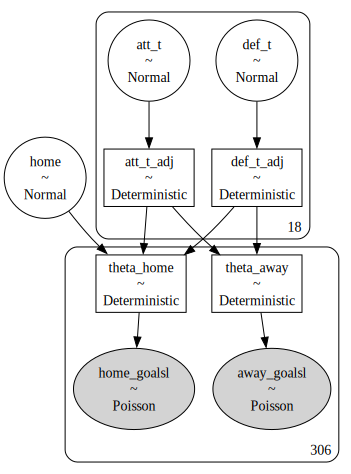

In [23]:
pm.model_to_graphviz(model1_2)

## Model 1.2 Prior Predictive Checks

In [24]:
with model1_2:
    idata1_2 = pm.sample_prior_predictive()

Sampling: [att_t, away_goalsl, def_t, home, home_goalsl]


In [25]:
idata1_2

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [26]:
az.summary(idata1_2.prior_predictive)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
away_goalsl[0]    1.268  1.327     0.0      4.0      0.064    0.045     418.0   
away_goalsl[1]    1.302  1.537     0.0      4.0      0.071    0.050     451.0   
away_goalsl[2]    1.236  1.435     0.0      4.0      0.061    0.044     559.0   
away_goalsl[3]    1.214  1.478     0.0      4.0      0.071    0.050     451.0   
away_goalsl[4]    1.256  1.467     0.0      4.0      0.063    0.045     508.0   
...                 ...    ...     ...      ...        ...      ...       ...   
home_goalsl[301]  2.008  2.133     0.0      5.0      0.093    0.068     548.0   
home_goalsl[302]  2.138  2.080     0.0      6.0      0.098    0.069     428.0   
home_goalsl[303]  2.074  2.075     0.0      6.0      0.090    0.066     553.0   
home_goalsl[304]  2.170  2.315     0.0      6.0      0.099    0.071     597.0   
home_goalsl[305]  2.156  2.342     0.0      6.0      0.112    0.079     404.0   

                  ess_tail  r_hat  
away_goalsl[0]       441.0    NaN  
away_goalsl[1]       524.0    NaN  
away_goalsl[2]       443.0    NaN  
away_goalsl[3]       452.0    NaN  
away_goalsl[4]       398.0    NaN  
...                    ...    ...  
home_goalsl[301]     525.0    NaN  
home_goalsl[302]     489.0    NaN  
home_goalsl[303]     482.0    NaN  
home_goalsl[304]     563.0    NaN  
home_goalsl[305]     395.0    NaN  

[612 rows x 9 columns]

In [27]:
with model1_2:
    idata1_2.extend(pm.sample())
    # idata1_2.extend(pm.sample(tune=2000, target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [28]:
idata1_2

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

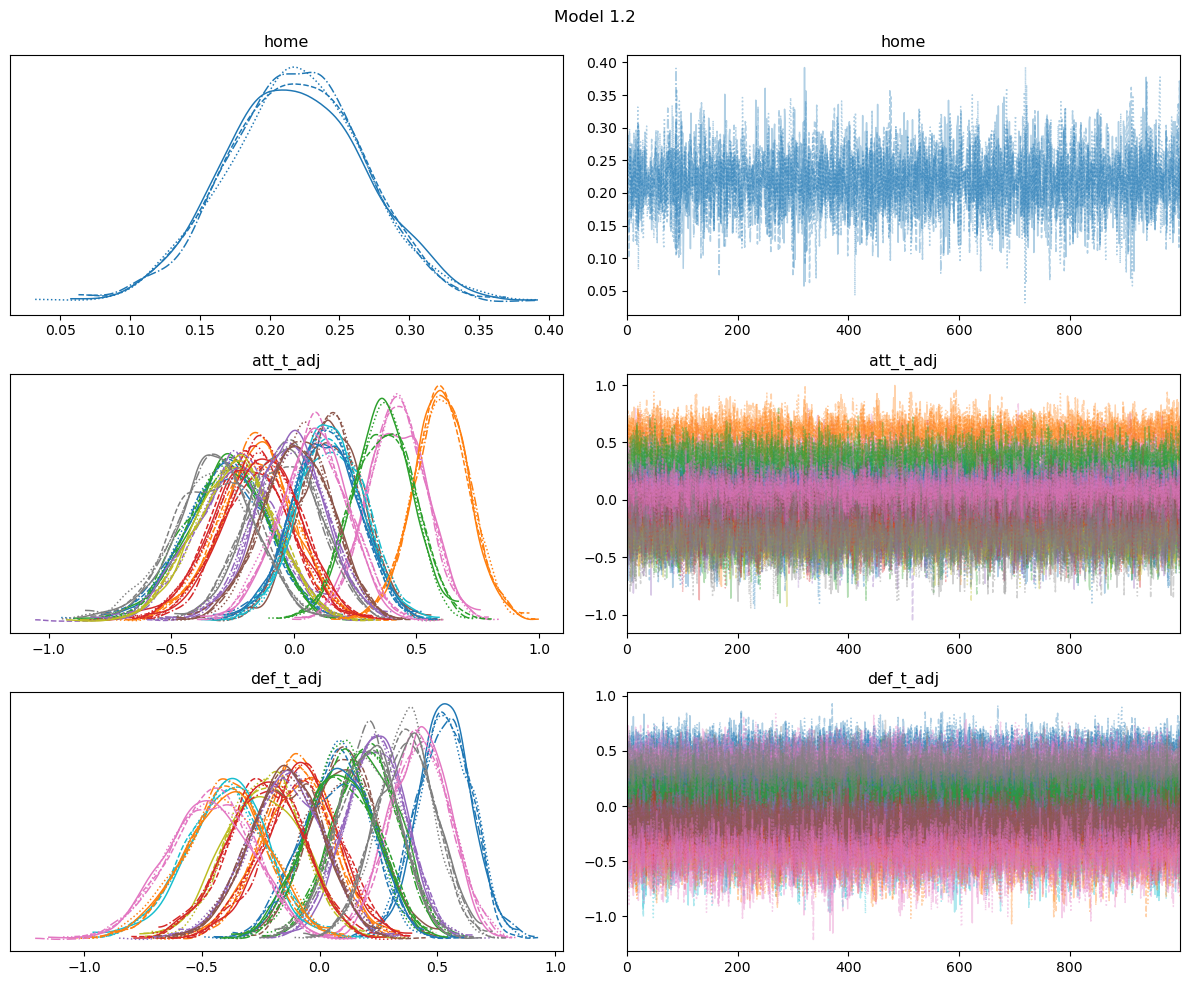

In [29]:
az.plot_trace(idata1_2, var_names=['^home$', 't_adj'], filter_vars='regex', figsize=(12, 10))
plt.suptitle('Model 1.2')
plt.tight_layout()
plt.show();

In [30]:
summ1_2 = az.summary(idata1_2)
summ1_2

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
home             0.218  0.050   0.124    0.311      0.001    0.000    7955.0   
att_t[0]         1.218  0.208   0.814    1.599      0.005    0.003    1838.0   
att_t[1]         1.342  0.199   0.971    1.711      0.005    0.004    1545.0   
att_t[2]         1.221  0.205   0.831    1.615      0.005    0.004    1621.0   
att_t[3]         1.314  0.201   0.907    1.659      0.005    0.003    1779.0   
...                ...    ...     ...      ...        ...      ...       ...   
theta_away[301]  0.939  0.193   0.584    1.291      0.002    0.002    9191.0   
theta_away[302]  1.070  0.215   0.676    1.454      0.002    0.002   10380.0   
theta_away[303]  0.693  0.157   0.409    0.986      0.002    0.001   11605.0   
theta_away[304]  2.824  0.494   1.914    3.721      0.006    0.004    7797.0   
theta_away[305]  1.071  0.224   0.658    1.476      0.002    0.002   11118.0   

                 ess_tail  r_hat  
home               2631.0    1.0  
att_t[0]           2429.0    1.0  
att_t[1]           2304.0    1.0  
att_t[2]           2465.0    1.0  
att_t[3]           2690.0    1.0  
...                   ...    ...  
theta_away[301]    2705.0    1.0  
theta_away[302]    2860.0    1.0  
theta_away[303]    2812.0    1.0  
theta_away[304]    2707.0    1.0  
theta_away[305]    2790.0    1.0  

[685 rows x 9 columns]

In [31]:
att_effect = summ1_2.filter(regex='att_t_adj', axis=0)['mean'].rename('mean_attack_effect').reset_index(drop=True)
def_effect = summ1_2.filter(regex='def_t_adj', axis=0)['mean'].rename('mean_defence_effect').reset_index(drop=True)
non_hier_effects = pd.concat([att_effect, def_effect], axis=1)
non_hier_effects.index = list(team_dict.keys())
non_hier_effects['model'] = 'non-hier'
non_hier_effects

mean_attack_effect  mean_defence_effect     model
Ascoli                  -0.278                0.529  non-hier
Atalanta                -0.155               -0.100  non-hier
Bari                    -0.276                0.196  non-hier
Cagliari                -0.183               -0.080  non-hier
Cremonese               -0.246                0.232  non-hier
Fiorentina               0.149                0.096  non-hier
Foggia                   0.419                0.423  non-hier
Genoa                   -0.041                0.203  non-hier
Inter                   -0.242               -0.237  non-hier
Juventus                 0.145               -0.399  non-hier
Lazio                    0.128                0.075  non-hier
Milan                    0.600               -0.400  non-hier
Napoli                   0.361                0.089  non-hier
Parma                   -0.134               -0.233  non-hier
Roma                    -0.014               -0.147  non-hier
Sampdoria                0.013               -0.144  non-hier
Torino                   0.081               -0.467  non-hier
Verona                  -0.326                0.365  non-hier

In [32]:
# p = (ggplot(non_hier_effects, aes(x='mean_attack_effect', y='mean_defence_effect')) +
#      geom_point(fill='none', color='black') +
#      geom_text(aes(label=non_hier_effects.index), color='black', size=8, nudge_y=0.05, va='bottom') +
#      geom_hline(yintercept=0.0, alpha=0.5) +
#      geom_vline(xintercept=0.0, alpha=0.5) +
#      labs(title='Model 1.2 - Non-hierarchical\nScatterplot of posterior Team Strengths',
#           x='mean attack', y='mean defence')
#      )
# p.draw()

## TODO - model 1.2
+ Plot of attack strength vs defence strength for named teams
+ insert team names
+ 
---

# Why Hierarchical ?
TODO

# Model 1.3 Back to Hierarchical with modified prior distributions
+ Hierarchical Model
+ Priors narrowed based on learning from non-hierarchical model
+ Prior distributions changed to more common distributions

In [33]:
with pm.Model() as model1_3:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.5/3)

    # hyper-priors
    mu_att = pm.Normal('mu_att', mu=1.5, sigma=0.5)
    sigma_att = pm.HalfNormal('sigma_att', sigma=1)    
    mu_def = pm.Normal('mu_def', mu=-1.5, sigma=0.5)
    sigma_def = pm.HalfNormal('sigma_def', sigma=1)

    # priors
    att_t = pm.Normal('att_t', mu=mu_att, sigma=sigma_att, shape=n_teams)
    def_t = pm.Normal('def_t', mu=mu_def, sigma=sigma_def, shape=n_teams)

    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

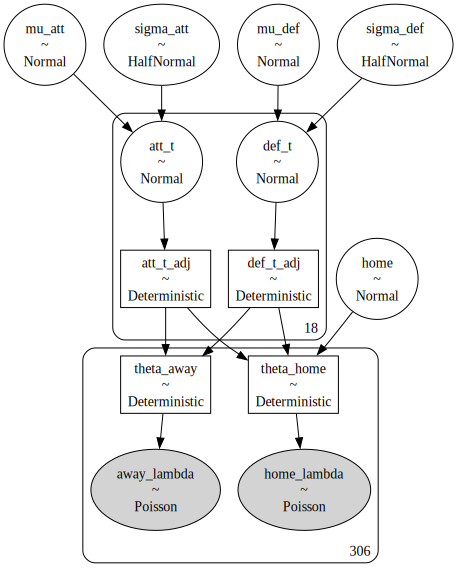

In [34]:
pm.model_to_graphviz(model1_3)

In [35]:
with model1_3:
    idata1_3 = pm.sample_prior_predictive()

Sampling: [att_t, away_lambda, def_t, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [36]:
with model1_3:
    idata1_3.extend(pm.sample())
#     # idata1_2.extend(pm.sample(tune=2000, target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t, def_t]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 61 divergences after tuning. Increase `target_accept` or reparameterize.


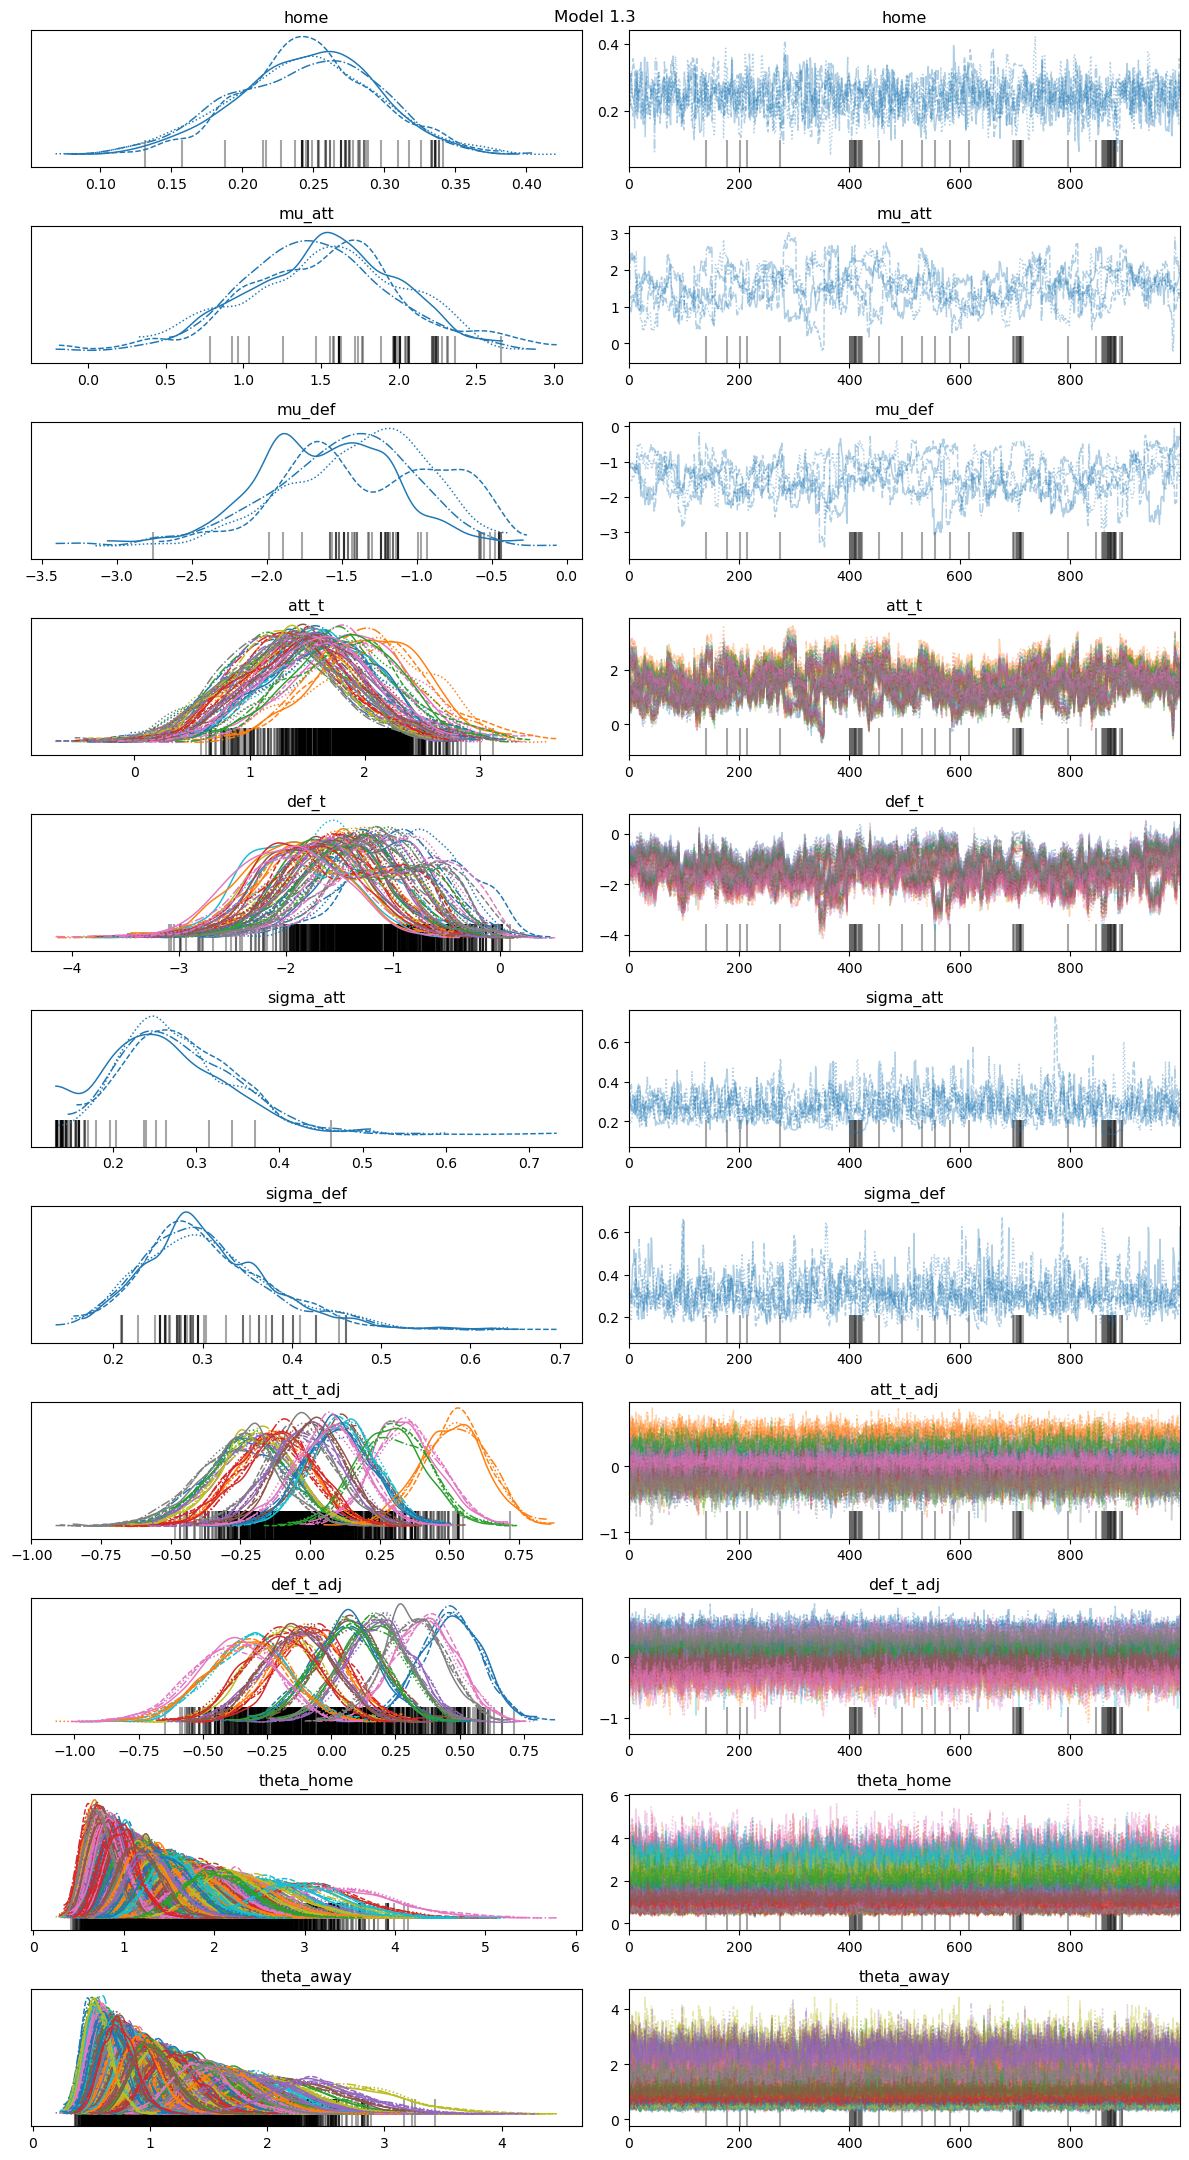

In [37]:
# az.plot_trace(idata1_3, var_names=['^home$', 't_adj'], filter_vars='regex', figsize=(12, 10))
az.plot_trace(idata1_3)
plt.suptitle('Model 1.3')
plt.tight_layout()
plt.show();

# Hierarchical Model Troubleshooting

# Model 1.4 - Non-centred Hierarchical Model
+ Non-centred parametrization

In [38]:
with pm.Model() as model1_4:
    # home advantage
    home = pm.Normal("home", mu=0.5, sigma=0.25)

    # hyper-priors
    mu_att_ = pm.Normal('mu_att', mu=0, sigma=0.5)
    sigma_att = pm.HalfNormal('sigma_att', sigma=0.333)    
    mu_def_ = pm.Normal('mu_def', mu=0, sigma=0.5)
    sigma_def = pm.HalfNormal('sigma_def', sigma=0.333)

    # offsets ?
    att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
    def_t_ = pm.Normal('def_t_', 0, 1, shape=n_teams)

    # priors    
    att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
    def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)

    
    # Apply zero sum constraint
    att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
    def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

    # log linear random effect model
    theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
    theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
    # likelihood
    home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
    away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

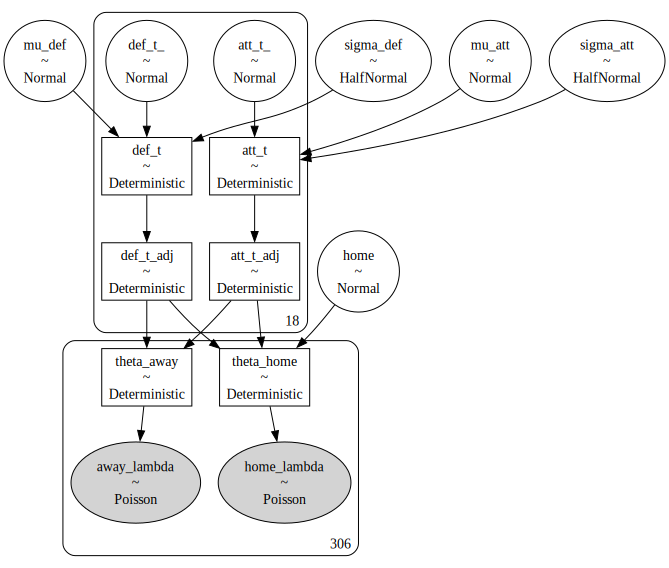

In [39]:
pm.model_to_graphviz(model1_4)

In [40]:
with model1_4:
    idata1_4 = pm.sample_prior_predictive()

Sampling: [att_t_, away_lambda, def_t_, home, home_lambda, mu_att, mu_def, sigma_att, sigma_def]


In [41]:
idata1_4

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data

In [42]:
with model1_4:
    # idata1_4.extend(pm.sample(4000, tune=2000))
    idata1_4.extend(pm.sample())

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [home, mu_att, sigma_att, mu_def, sigma_def, att_t_, def_t_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


In [43]:
with model1_4:
    pm.sample_posterior_predictive(trace=idata1_4, extend_inferencedata=True)

Sampling: [away_lambda, home_lambda]


In [44]:
idata1_4

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

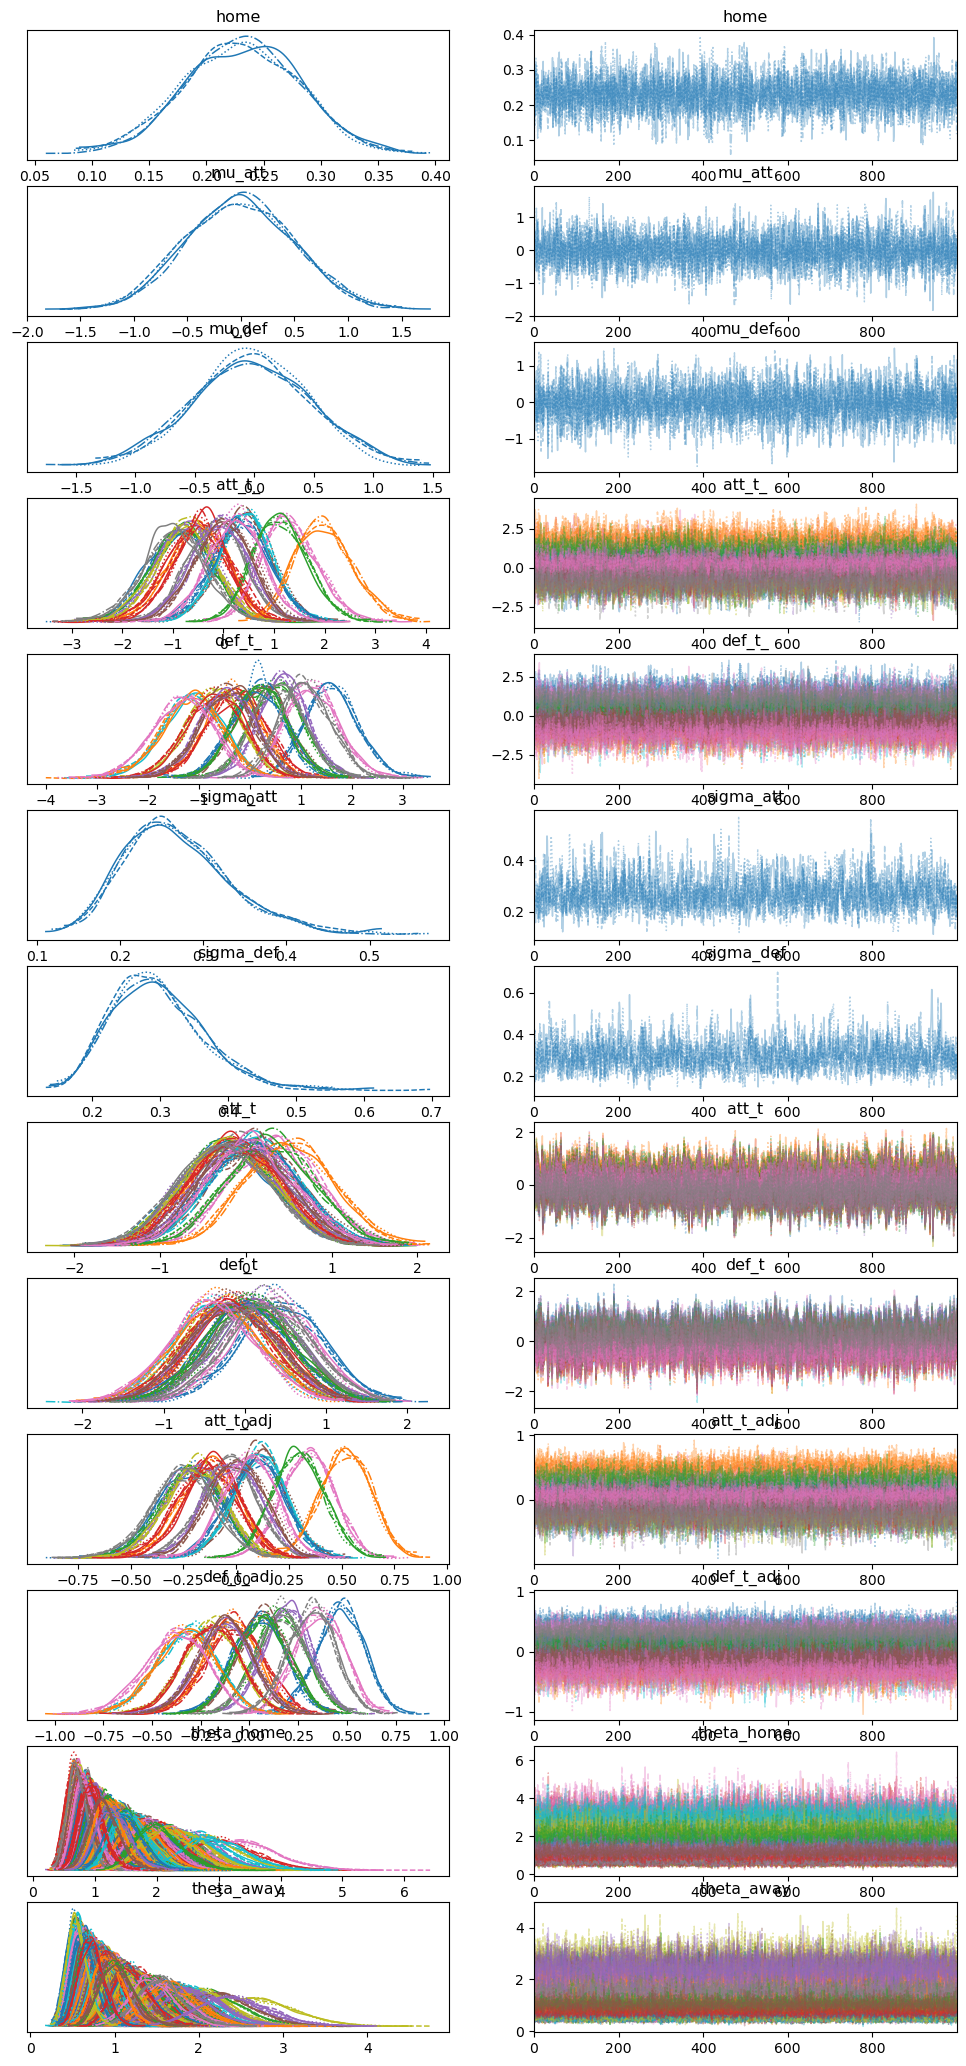

In [45]:
az.plot_trace(idata1_4);

# Comparison of model 1.4 Results to Original Paper

In [46]:
summ_1_4 = az.summary(idata1_4, hdi_prob=0.95).round(2)
summ_1_4

mean    sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
home             0.23  0.05      0.13       0.33       0.00     0.00   
mu_att          -0.01  0.51     -0.92       1.05       0.01     0.01   
mu_def          -0.02  0.49     -0.99       0.92       0.01     0.01   
att_t_[0]       -0.86  0.62     -2.04       0.32       0.01     0.01   
att_t_[1]       -0.50  0.59     -1.67       0.62       0.01     0.01   
...               ...   ...       ...        ...        ...      ...   
theta_away[301]  0.94  0.18      0.60       1.27       0.00     0.00   
theta_away[302]  1.04  0.20      0.66       1.41       0.00     0.00   
theta_away[303]  0.73  0.14      0.47       1.02       0.00     0.00   
theta_away[304]  2.45  0.42      1.64       3.28       0.01     0.00   
theta_away[305]  1.04  0.21      0.67       1.46       0.00     0.00   

                 ess_bulk  ess_tail  r_hat  
home               5035.0    2606.0    1.0  
mu_att             5519.0    3131.0    1.0  
mu_def             4790.0    3130.0    1.0  
att_t_[0]          4419.0    3058.0    1.0  
att_t_[1]          3504.0    2728.0    1.0  
...                   ...       ...    ...  
theta_away[301]    5638.0    3305.0    1.0  
theta_away[302]    5832.0    3184.0    1.0  
theta_away[303]    4756.0    3128.0    1.0  
theta_away[304]    5524.0    3222.0    1.0  
theta_away[305]    6278.0    3300.0    1.0  

[725 rows x 9 columns]

In [47]:
att_rows = summ_1_4.filter(regex='att_t_adj', axis=0).index.tolist()
atts = summ_1_4.loc[att_rows + ['home'], ['mean', 'hdi_2.5%', 'hdi_97.5%']]
atts.index = list(team_dict.keys()) + ['home']
atts

mean  hdi_2.5%  hdi_97.5%
Ascoli     -0.22     -0.51       0.06
Atalanta   -0.13     -0.42       0.12
Bari       -0.22     -0.49       0.08
Cagliari   -0.15     -0.44       0.12
Cremonese  -0.20     -0.46       0.07
Fiorentina  0.12     -0.12       0.37
Foggia      0.34      0.12       0.59
Genoa      -0.04     -0.30       0.23
Inter      -0.20     -0.48       0.07
Juventus    0.11     -0.15       0.35
Lazio       0.10     -0.15       0.36
Milan       0.52      0.29       0.75
Napoli      0.30      0.06       0.54
Parma      -0.11     -0.39       0.14
Roma       -0.02     -0.26       0.25
Sampdoria   0.00     -0.25       0.25
Torino      0.06     -0.18       0.30
Verona     -0.26     -0.57       0.03
home        0.23      0.13       0.33

In [48]:
idata1_4

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> prior
	> prior_predictive
	> observed_data

In [49]:
home_goals_df = idata1_4.posterior_predictive['home_lambda'].to_dataframe()
away_goals_df = idata1_4.posterior_predictive['away_lambda'].to_dataframe()
scores_df = pd.concat([home_goals_df, away_goals_df], axis=1).droplevel((0,1), axis=0).reset_index().rename(columns={'index': 'game_num'})
scores_df

game_num  home_lambda  away_lambda
0               0            2            5
1               1            3            1
2               2            1            2
3               3            2            3
4               4            0            3
...           ...          ...          ...
1223995       301            1            3
1223996       302            3            1
1223997       303            1            0
1223998       304            1            3
1223999       305            0            1

[1224000 rows x 3 columns]

In [50]:
game_probs = []
for game_num, game_df in scores_df.groupby(by=['game_num']):
    p_hwin = (game_df['home_lambda'] > game_df['away_lambda']).sum() / len(game_df)
    p_draw = (game_df['home_lambda'] == game_df['away_lambda']).sum() / len(game_df)
    p_awin = (game_df['home_lambda'] < game_df['away_lambda']).sum() / len(game_df)
    game_probs.append(pd.DataFrame({'p(hwin)pred': [p_hwin], 'p(draw)pred': [p_draw], 'p(awin)pred': [p_awin]}, index=game_num))
probs_df = pd.concat(game_probs, axis=0)
df_res = pd.concat([df, probs_df, pd.get_dummies(df['result']).astype(int)], axis=1)
df_res    

g      home        away  hg  ag  yg1  yg2 result  p(hwin)pred  \
0      0    Verona        Roma  17  14  0.0  1.0   awin      0.23700   
1      1    Napoli    Atalanta  12   1  1.0  0.0   hwin      0.51975   
2      2     Lazio       Parma  10  13  1.0  1.0   draw      0.41050   
3      3  Juventus  Fiorentina   9   5  1.0  0.0   hwin      0.53725   
4      4     Inter      Foggia   8   6  1.0  1.0   draw      0.44950   
..   ...       ...         ...  ..  ..  ...  ...    ...          ...   
301  301     Parma  Fiorentina  13   5  1.0  1.0   draw      0.43775   
302  302    Napoli       Genoa  12   7  1.0  0.0   hwin      0.59125   
303  303     Inter    Atalanta   8   1  0.0  0.0   draw      0.40975   
304  304    Foggia       Milan   6  11  2.0  8.0   awin      0.20200   
305  305  Cagliari       Lazio   3  10  0.0  1.0   awin      0.39575   

     p(draw)pred  p(awin)pred  awin  draw  hwin  
0        0.28125      0.48175     1     0     0  
1        0.25675      0.22350     0     0     1  
2        0.27900      0.31050     0     1     0  
3        0.25800      0.20475     0     0     1  
4        0.26675      0.28375     0     1     0  
..           ...          ...   ...   ...   ...  
301      0.28350      0.27875     0     1     0  
302      0.21225      0.19650     0     0     1  
303      0.32275      0.26750     0     1     0  
304      0.17650      0.62150     1     0     0  
305      0.28225      0.32200     1     0     0  

[306 rows x 14 columns]

In [51]:
# df_res = pd.concat([probs_df, pd.get_dummies(df_res['result'])], axis=1)
# df_res

In [52]:
# stop

In [53]:
# theta_home_mean_ser = summ_df.filter(regex='theta_home', axis=0)['mean'].rename('theta_home_mean').reset_index(drop=True)
# theta_away_mean_ser = summ_df.filter(regex='theta_away', axis=0)['mean'].rename('theta_away_mean').reset_index(drop=True)
# df_res = pd.concat([df, theta_home_mean_ser, theta_away_mean_ser], axis=1)
# df_res

In [54]:
# # TODO - Remove and use distributions from model
# # https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/
# def win_draw_loss(home_expectation, away_expectation, max_goals=10):
#     h = poisson.pmf(range(max_goals+1), home_expectation)
#     a = poisson.pmf(range(max_goals+1), away_expectation)    
#     m = np.outer(h, a)

#     home = np.sum(np.tril(m, -1))
#     away = np.sum(np.triu(m, 1))
#     draw = np.sum(np.diag(m))

#     return home, draw, away

In [55]:
# df_res[['p(hwinc)', 'p(drawc)', 'p(awinc)']] = df_res.apply(lambda x: win_draw_loss(x.theta_home_mean, x.theta_away_mean),
#                                                          axis=1, result_type='expand')
# df_res = pd.concat([df_res, pd.get_dummies(df_res['result'])], axis=1)
# df_res

In [56]:
dfc = df_res.copy()
n_bins = 5
strategy='quantile'
pred_cols=['p(hwin)pred', 'p(draw)pred', 'p(awin)pred']
n_matches = len(dfc)
cal_df = make_1x2_calib_data(dfc, n_bins=n_bins, strategy=strategy, pred_cols=pred_cols)
cal_df.head()

bin_num  mean_predicted_proba  mean_actual_proba  bin_count  prob_pred  \
0        0              0.234641           0.129032         62   0.234641   
1        1              0.341861           0.327869         61   0.341861   
2        2              0.420311           0.278689         61   0.420311   
3        3              0.505320           0.557377         61   0.505320   
4        4              0.648496           0.803279         61   0.648496   

   bin_count  25.0%_CI  75.0%_CI calib  
0         62  0.198341  0.270942  hwin  
1         61  0.300897  0.382824  hwin  
2         61  0.377684  0.462939  hwin  
3         61  0.462142  0.548497  hwin  
4         61  0.607264  0.689727  hwin

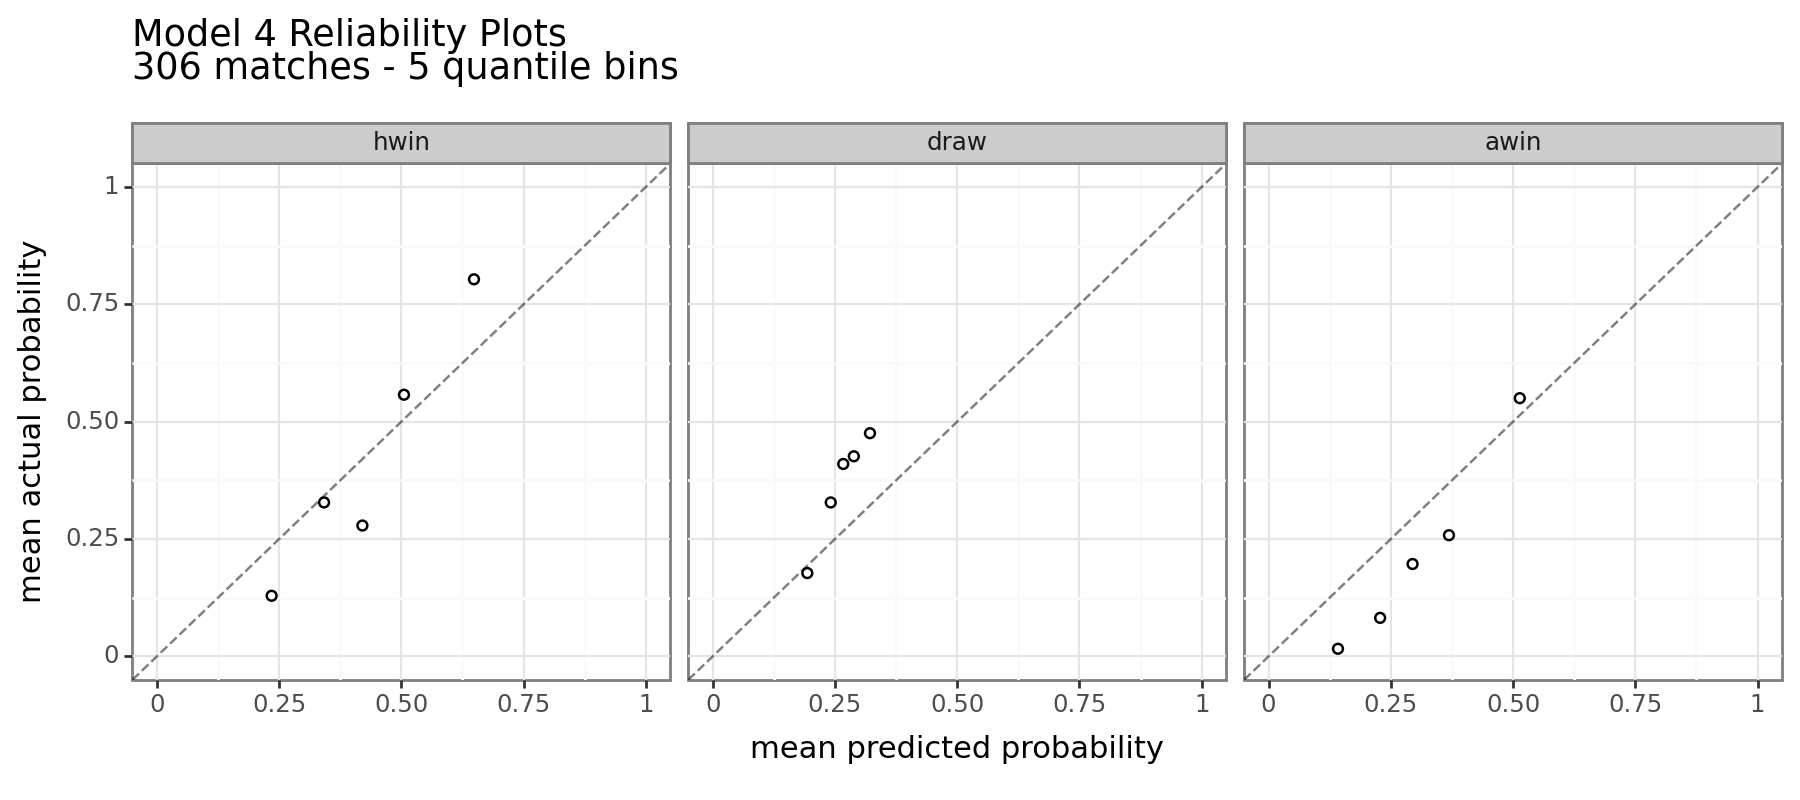

In [57]:
p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
     geom_point(fill='none') +
     # geom_errorbarh(aes(xmin='2.5%_CI', xmax='97.5%_CI'), height=0.025, alpha=0.3) +
     geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
     coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
     labs(x='mean predicted probability',
          y='mean actual probability',
          title=f'Model 4 Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
     facet_wrap('calib') +
     theme(figure_size=(9,4))
    )
plt.close()
p.draw()

# Shrinkage

In [58]:
att_effect = summ_1_4.filter(regex='att_t_adj', axis=0)['mean'].rename('mean_attack_effect').reset_index(drop=True)
def_effect = summ_1_4.filter(regex='def_t_adj', axis=0)['mean'].rename('mean_defence_effect').reset_index(drop=True)
hier_effects = pd.concat([att_effect, def_effect], axis=1)
hier_effects.index = list(team_dict.keys())
hier_effects['model'] = 'hier'
hier_effects

mean_attack_effect  mean_defence_effect model
Ascoli                   -0.22                 0.47  hier
Atalanta                 -0.13                -0.09  hier
Bari                     -0.22                 0.16  hier
Cagliari                 -0.15                -0.07  hier
Cremonese                -0.20                 0.20  hier
Fiorentina                0.12                 0.07  hier
Foggia                    0.34                 0.36  hier
Genoa                    -0.04                 0.17  hier
Inter                    -0.20                -0.20  hier
Juventus                  0.11                -0.32  hier
Lazio                     0.10                 0.05  hier
Milan                     0.52                -0.33  hier
Napoli                    0.30                 0.06  hier
Parma                    -0.11                -0.20  hier
Roma                     -0.02                -0.13  hier
Sampdoria                 0.00                -0.12  hier
Torino                    0.06                -0.38  hier
Verona                   -0.26                 0.32  hier

In [59]:
full_effects = pd.concat([non_hier_effects, hier_effects], axis=0)
full_effects

mean_attack_effect  mean_defence_effect     model
Ascoli                  -0.278                0.529  non-hier
Atalanta                -0.155               -0.100  non-hier
Bari                    -0.276                0.196  non-hier
Cagliari                -0.183               -0.080  non-hier
Cremonese               -0.246                0.232  non-hier
Fiorentina               0.149                0.096  non-hier
Foggia                   0.419                0.423  non-hier
Genoa                   -0.041                0.203  non-hier
Inter                   -0.242               -0.237  non-hier
Juventus                 0.145               -0.399  non-hier
Lazio                    0.128                0.075  non-hier
Milan                    0.600               -0.400  non-hier
Napoli                   0.361                0.089  non-hier
Parma                   -0.134               -0.233  non-hier
Roma                    -0.014               -0.147  non-hier
Sampdoria                0.013               -0.144  non-hier
Torino                   0.081               -0.467  non-hier
Verona                  -0.326                0.365  non-hier
Ascoli                  -0.220                0.470      hier
Atalanta                -0.130               -0.090      hier
Bari                    -0.220                0.160      hier
Cagliari                -0.150               -0.070      hier
Cremonese               -0.200                0.200      hier
Fiorentina               0.120                0.070      hier
Foggia                   0.340                0.360      hier
Genoa                   -0.040                0.170      hier
Inter                   -0.200               -0.200      hier
Juventus                 0.110               -0.320      hier
Lazio                    0.100                0.050      hier
Milan                    0.520               -0.330      hier
Napoli                   0.300                0.060      hier
Parma                   -0.110               -0.200      hier
Roma                    -0.020               -0.130      hier
Sampdoria                0.000               -0.120      hier
Torino                   0.060               -0.380      hier
Verona                  -0.260                0.320      hier

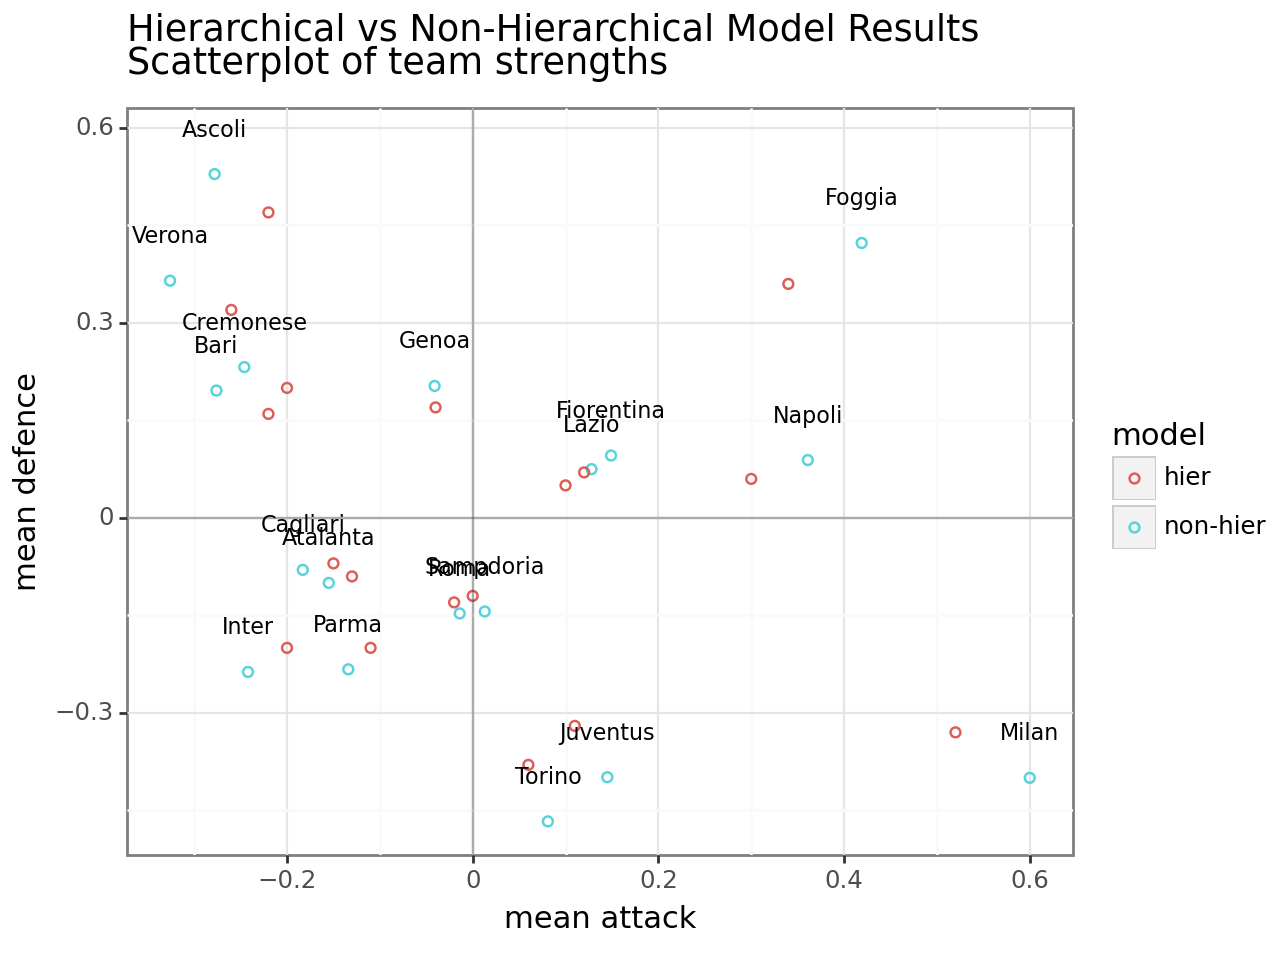

In [60]:
p = (ggplot(full_effects, aes(x='mean_attack_effect', y='mean_defence_effect', color='model')) +
     geom_point(fill='none') +
     geom_text(non_hier_effects, aes(label=non_hier_effects.index), color='black', size=8, nudge_y=0.05, va='bottom') +
     geom_hline(yintercept=0.0, alpha=0.25) +
     geom_vline(xintercept=0.0, alpha=0.25) +
     labs(title='Hierarchical vs Non-Hierarchical Model Results\nScatterplot of team strengths',
          x='mean attack', y='mean defence')
     )
p.draw()

# Summary

In [61]:
# stop

# Model 4
+ Non-centred parametrization
+ priors opened up
+ Add coords for easier interpretation

In [62]:
# TODO COORDS

In [63]:
# with pm.Model() as model4:
#     # home advantage
#     home = pm.Normal("home", mu=0.0, sigma=1.0)

#     # hyper-priors
#     mu_att_ = pm.Normal('mu_att', mu=0, sigma=1.0)
#     sigma_att = pm.HalfNormal('sigma_att', sigma=1.0)    
#     mu_def_ = pm.Normal('mu_def', mu=0, sigma=1.0)
#     sigma_def = pm.HalfNormal('sigma_def', sigma=1.0)

#     att_t_ = pm.Normal("att_t_", 0, 1, shape=n_teams)
#     def_t_ = pm.Normal('def_t_', 0,1, shape=n_teams)

#     # priors    
#     att_t = pm.Deterministic('att_t', mu_att_ + att_t_ * sigma_att)
#     def_t = pm.Deterministic('def_t', mu_def_ + def_t_ * sigma_def)
    
#     # Apply zero sum constraint
#     att_t_adj = pm.Deterministic("att_t_adj", att_t - pt.mean(att_t))
#     def_t_adj = pm.Deterministic('def_t_adj', def_t - pt.mean(def_t))

#     # log linear random effect model
#     theta_home = pm.Deterministic('theta_home', pt.exp(home + att_t_adj[home_idx] + def_t_adj[away_idx]))
#     theta_away = pm.Deterministic('theta_away', pt.exp(att_t_adj[away_idx] + def_t_adj[home_idx]))
    
#     # likelihood
#     home_lambda = pm.Poisson('home_lambda', mu=theta_home, observed=home_goals)
#     away_lambda = pm.Poisson('away_lambda', mu=theta_away, observed=away_goals)

In [64]:
# with model4:
#     idata = pm.sample_prior_predictive()

In [65]:
# idata

In [66]:
# with model4:
#     idata = pm.sample()

In [67]:
# az.plot_trace(idata);

# Model 4 Appraisal
+ Reproduction of original results
+ Calibration

In [68]:
# summ_df = az.summary(idata, hdi_prob=0.95).round(2)
# summ_df

In [69]:
# att_rows = summ_df.filter(regex='att_t_adj', axis=0).index.tolist()
# atts = summ_df.loc[['home'] + att_rows, ['mean', 'hdi_2.5%', 'hdi_97.5%']]
# atts

In [70]:
# theta_home_mean_ser = summ_df.filter(regex='theta_home', axis=0)['mean'].rename('theta_home_mean').reset_index(drop=True)
# theta_away_mean_ser = summ_df.filter(regex='theta_away', axis=0)['mean'].rename('theta_away_mean').reset_index(drop=True)
# df_res = pd.concat([df, theta_home_mean_ser, theta_away_mean_ser], axis=1)
# df_res

In [71]:
# # TODO - Remove and use distributions from model
# # https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/
# def win_draw_loss(home_expectation, away_expectation, max_goals=10):
#     h = poisson.pmf(range(max_goals+1), home_expectation)
#     a = poisson.pmf(range(max_goals+1), away_expectation)    
#     m = np.outer(h, a)

#     home = np.sum(np.tril(m, -1))
#     away = np.sum(np.triu(m, 1))
#     draw = np.sum(np.diag(m))

#     return home, draw, away

In [72]:
# df_res[['p(hwinc)', 'p(drawc)', 'p(awinc)']] = df_res.apply(lambda x: win_draw_loss(x.theta_home_mean, x.theta_away_mean),
#                                                          axis=1, result_type='expand')
# df_res = pd.concat([df_res, pd.get_dummies(df_res['result'])], axis=1)
# df_res

In [73]:
# dfc = df_res.copy()
# n_bins = 5
# strategy='quantile'
# n_matches = len(dfc)
# cal_df = make_1x2_calib_data(dfc, n_bins=n_bins, strategy=strategy, error_bar_alpha=0.05)
# cal_df.head()

In [74]:
# p = (ggplot(cal_df, aes(x='mean_predicted_proba', y='mean_actual_proba', group='calib')) +
#      geom_point(fill='none') +
#      # geom_errorbarh(aes(xmin='2.5%_CI', xmax='97.5%_CI'), height=0.025, alpha=0.3) +
#      geom_abline(intercept=0, slope=1, alpha=0.5, linetype='dashed') +
#      coord_cartesian(xlim=(0, 1.0), ylim=(0, 1.0)) +
#      labs(x='mean predicted probability',
#           y='mean actual probability',
#           title=f'Model 4 Reliability Plots\n{n_matches} matches - {n_bins} {strategy} bins') +
#      facet_wrap('calib') +
#      theme(figure_size=(9,4))
#     )
# plt.close()
# p.draw()

Changes to make a hierarchical model non-centred

with pm.Model() as hierarchical_model_non_centered:
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sd=100**2)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    mu_b = pm.Normal('mu_b', mu=0., sd=100**2)
    sigma_b = pm.HalfCauchy('sigma_b', 5)

    # Before:
    # a = pm.Normal('a', mu=mu_a, sd=sigma_a, shape=n_counties)
    # Transformed:
    a_offset = pm.Normal('a_offset', mu=0, sd=1, shape=n_counties)
    a = pm.Deterministic("a", mu_a + a_offset * sigma_a)

    # Before:
    # b = pm.Normal('b', mu=mu_b, sd=sigma_b, shape=n_counties)
    # Now:
    b_offset = pm.Normal('b_offset', mu=0, sd=1, shape=n_counties)
    b = pm.Deterministic("b", mu_b + b_offset * sigma_b)

    # Model error
    eps = pm.HalfCauchy('eps', 5)
    
    radon_est = a[county_idx] + b[county_idx] * data.floor.values
    
    # Data likelihood
    radon_like = pm.Normal('radon_like', mu=radon_est, sd=eps, observed=data.log_radon)


# Resources
+ [Predicting Football Results With Statistical Modelling (webpage) - David Sheehan](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)
+ [Bayesian hierarchical model for the prediction of football results (pdf) - Gianluca Baio1 & Marta A. Blangiardo 2010](https://discovery.ucl.ac.uk/id/eprint/16040/1/16040.pdf)
+ [Analysis of sports data by using bivariate
Poisson models (pdf) - Dimitris Karlis & Ioannis Ntzoufras](http://www2.stat-athens.aueb.gr/~jbn/papers2/08_Karlis_Ntzoufras_2003_RSSD.pdf)
+ [Predicting Football Results Using Bayesian Modelling with Python and PyMC3 (webpage) -  Martin Eastwood - pena.lt/y blog](https://pena.lt/y/2021/08/25/predicting-football-results-using-bayesian-statistics-with-python-and-pymc3/)
+ [Hierarchical Modelling in Stan: Predicting the Premier League (YouTube video & associated material) -  Maggie Lieu - Stan Youtube channel](https://www.youtube.com/watch?v=dNZQrcAjgXQ&list=PLdw9iy95A5dh9tr3ZEiPICRYu8geqi9N9&index=103)
+ [Why hierarchical models are awesome, tricky, and Bayesian (webpage) - Thomas Wiecki - twiecki.io website](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/)
+ [Diagnosing Biased Inference with Divergences (webpage) - pymc documentation](https://www.pymc.io/projects/examples/en/latest/diagnostics_and_criticism/Diagnosing_biased_Inference_with_Divergences.html)
+ [Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results (github repository) - liotti2085 - github](https://github.com/liotti2085/Bayesian-Hierarchical-Model-for-the-Prediction-of-Soccer-Results/tree/main)
+ Data Sources
    + [Italy Serie A 1992-1993](https://fbref.com/en/comps/11/1992-1993/schedule/1992-1993-Serie-A-Scores-and-Fixtures) from fbref.com
    + [Italy Serie A 2007-2008](https://www.football-data.co.uk/italym.php) from football-data.co.uk
    + [Fixture Download website](https://fixturedownload.com/) includes future fixtures

## Original winBUGS code
```
model {
# LIKELIHOOD AND RANDOM EFFECT MODEL FOR THE SCORING PROPENSITY
for (g in 1:ngames) {
# Observed number of goals scored by each team
y1[g] ~ dpois(theta[g,1])
y2[g] ~ dpois(theta[g,2])
# Predictive distribution for the number of goals scored
ynew[g,1] ~ dpois(theta[g,1])
ynew[g,2] ~ dpois(theta[g,2])
# Average Scoring intensities (accounting for mixing components)
log(theta[g,1]) <- home + att[hometeam[g]] + def[awayteam[g]]
log(theta[g,2]) <- att[awayteam[g]] + def[hometeam[g]]
}
# 1. BASIC MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Trick to code the ‘‘sum-to-zero’’ constraint
for (t in 1:nteams){
att.star[t] ~ dnorm(mu.att,tau.att)
def.star[t] ~ dnorm(mu.def,tau.def)
att[t] <- att.star[t] - mean(att.star[])
def[t] <- def.star[t] - mean(def.star[])
}
# priors on the random effects
mu.att ~ dnorm(0,0.0001)
mu.def ~ dnorm(0,0.0001)
tau.att ~ dgamma(.01,.01)
tau.def ~ dgamma(.01,.01)
# 2. MIXTURE MODEL FOR THE HYPERPARAMETERS
# prior on the home effect
home ~ dnorm(0,0.0001)
# Mixture parameters & components (‘‘sum-to-zero’’ constraint)
for (t in 1:nteams){
grp.att[t] ~ dcat(p.att[t,])
grp.def[t] ~ dcat(p.def[t,])
att[t] ~ dt(mu.att[grp.att[t]],tau.att[grp.att[t]],4)
def[t] ~ dt(mu.def[grp.def[t]],tau.def[grp.def[t]],4)
att.star[t] <- att[t] - mean(att[])
def.star[t] <- def[t] - mean(def[])
# Priors on the mixture parameter (team specific)
p.att[t,1:3] ~ ddirch(prior.att[t,])
p.def[t,1:3] ~ ddirch(prior.def[t,])
}
# Priors on the random effects
# group 1: bottom-table teams
mu.att[1] ~ djl.dnorm.trunc(0,0.001,-3,0)
mu.def[1] ~ djl.dnorm.trunc(0,0.001,0,3)
tau.att[1] ~ dgamma(0.01,0.01)
tau.def[1] ~ dgamma(0.01,0.01)
# group 2: mid-table teams
mu.att[2] <-0
mu.def[2] <-0
tau.att[2] ~ dgamma(0.01,0.01)
tau.def[2] ~ dgamma(0.01,0.01)
# group 3: top-table teams
mu.att[3] ~ djl.dnorm.trunc(0,0.001,0,3)
mu.def[3] ~ djl.dnorm.trunc(0,0.001,-3,0)
tau.att[3] ~ dgamma(0.01,0.01)
tau.def[3] ~ dgamma(0.01,0.01)
}
```